# Cars Classification by Image

Соревнование на Kaggle: **[[>](https://www.kaggle.com/c/sf-dl-car-classification)]**


# Imports and Settings

In [1]:
!nvidia-smi 

Wed Sep 15 07:25:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pavelmoskvitin","key":"00e629004572316703eebe43748ee4ef"}'}

In [4]:
!pip install -q kaggle

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c sf-dl-car-classification 

  0% 0.00/78.7k [00:00<?, ?B/s]
100% 78.7k/78.7k [00:00<00:00, 29.7MB/s]
  0% 0.00/196k [00:00<?, ?B/s]
100% 196k/196k [00:00<00:00, 64.5MB/s]
100% 1.10G/1.11G [00:04<00:00, 237MB/s]
100% 1.11G/1.11G [00:04<00:00, 241MB/s]
 94% 461M/489M [00:02<00:00, 213MB/s]
100% 489M/489M [00:02<00:00, 196MB/s]
Error in sys.exitfunc:
Traceback (most recent call last):
  File "/usr/lib/python2.7/atexit.py", line 29, in _run_exitfuncs
    print >> sys.stderr, "Error in atexit._run_exitfuncs:"
KeyboardInterrupt


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import zipfile
import csv
import sys
import os
from datetime import timedelta, datetime as dt
from time import time

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (LearningRateScheduler, ModelCheckpoint,
                                        EarlyStopping, ReduceLROnPlateau)
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import (EfficientNetB0, EfficientNetB3, 
                                           EfficientNetB4, EfficientNetB5, 
                                           EfficientNetB6, EfficientNetB7)
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential as S
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
# Улучшим вид графиков в svg
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

print(os.listdir('/content/'), '\n')
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)
GPU = tf.config.list_physical_devices('GPU')
print('GPU is', 'available' if GPU else 'NOT AVAILABLE')

['.config', 'drive', 'kaggle.json', 'requirements.txt', 'sample_data'] 

Python       : 3.7.11 (default, Jul  3 2021, 18:01:19) 
Numpy        : 1.19.5
Tensorflow   : 2.6.0
Keras        : 2.6.0
GPU is available


In [10]:
# Фиксируем версии всех пакетов для воспроизводимости
!pip freeze > requirements.txt

# Устаналиваем конкретное значение random seed для воспроизводимости
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/deep learning/'
WORK_PATH = '/content/drive/MyDrive/Colab Notebooks/deep learning/'  # рабочая директория
os.makedirs(WORK_PATH, exist_ok=True)

sample_submission = pd.read_csv(DATA_PATH + 'sample-submission.csv')

train_df = pd.read_csv(DATA_PATH + 'train.csv')

### Load and Extract Data

In [11]:
%%time

print('Распаковываем картинки.. ', end='')

for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH + data_zip, 'r') as z:
        z.extractall(WORK_PATH)
        
print('Готово')
print(os.listdir(WORK_PATH))

Распаковываем картинки.. Готово
['sample-submission.csv', 'test.zip', 'train.zip', 'train.csv', '.ipynb_checkpoints', 'best_model.hdf5', 'train', 'test_upload']
CPU times: user 15.3 s, sys: 8.66 s, total: 23.9 s
Wall time: 3min 13s


# EDA / Анализ данных

In [12]:
# Для начала ознакомимся с данными:
print(train_df.head())
print()
print(train_df.info())

           Id  Category
0  100155.jpg         0
1  100306.jpg         0
2  100379.jpg         0
3  100380.jpg         0
4  100389.jpg         0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB
None


In [13]:
train_df.Category

0        0
1        0
2        0
3        0
4        0
        ..
15556    9
15557    9
15558    9
15559    9
15560    9
Name: Category, Length: 15561, dtype: int64

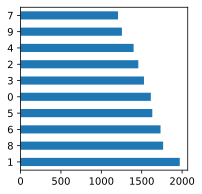

In [14]:
train_df.Category.value_counts().plot(kind='barh', figsize=(3, 3));

Распределение классов достаточно равномерное - это хорошо

In [16]:
from PIL import Image

Примеры картинок (random samples):


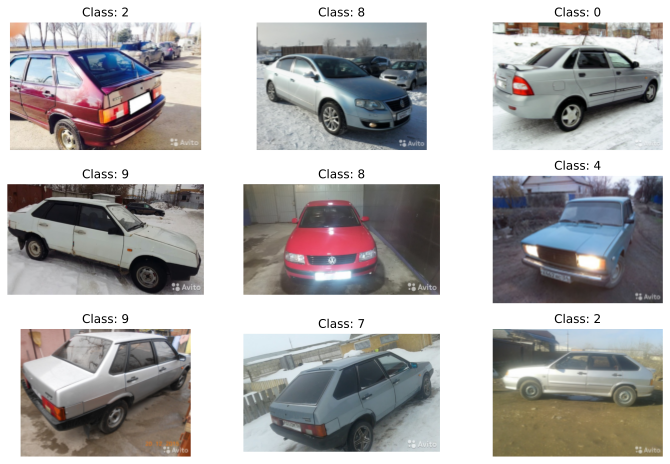

In [17]:
print('Примеры картинок (random samples):')
plt.figure(figsize=(12, 8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = Image.open(WORK_PATH + f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('Class: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на пример картинки и её размер:

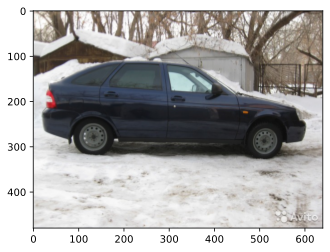

(640, 480)

In [18]:
image = Image.open(WORK_PATH + '/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

In [19]:
# Словарь с некорректными картинками в обучающей выборке - эти изображения удаляем из набора
bad_imgs = {'0': 
        ['23675.jpg',
          '106274.jpg',
          '108635.jpg',
          '111745.jpg',
          '118468.jpg',
          '170545.jpg',
          '184454.jpg',
          '214149.jpg',
          '242897.jpg',
          '260934.jpg',
          '283917.jpg',
          '289476.jpg',
          '291089.jpg'], 
        '1': 
          ['2175.jpg',
          '19615.jpg',
          '100255.jpg',
          '106364.jpg',
          '111955.jpg',
          '118004.jpg',
          '161397.jpg',
          '162799.jpg',
          '171717.jpg',
          '190704.jpg',
          '211992.jpg',
          '213653.jpg',
          '234776.jpg'], 
        '2': 
         ['21819.jpg',
          '149921.jpg',
          '162828.jpg',
          '271465.jpg',
          '292641.jpg'],
        '3': 
         ['12080.jpg',
         '19672.jpg',
         '19817.jpg',
         '103321.jpg',
         '121693.jpg',
         '122947.jpg',
         '135372.jpg',
         '141052.jpg',
         '147457.jpg',
         '151120.jpg',
         '152125.jpg',
         '186470.jpg',
         '247500.jpg',
         '274933.jpg'], 
        '4': 
        ['271739.jpg',
         '251322.jpg',
         '250923.jpg',
         '236077.jpg',
         '202547.jpg',
         '188072.jpg',
         '176702.jpg',
         '174231.jpg',
         '167534.jpg',
         '151652.jpg',
         '135843.jpg',
         '115799.jpg',
         '107922.jpg',
         '100968.jpg',
         '1620.jpg'],
        '5': 
        ['267513.jpg',
        '262518.jpg',
        '258686.jpg',
        '245175.jpg',
        '198229.jpg',
        '188543.jpg',
        '128234.jpg',
        '110732.jpg',
        '110600.jpg',
        '107173.jpg',
        '104396.jpg'], 
        '6': 
        ['292194.jpg',
        '252178.jpg',
        '247036.jpg',
        '240371.jpg',
        '228602.jpg',
        '203539.jpg',
        '193236.jpg',
        '179955.jpg',
        '172352.jpg',
        '167237.jpg',
        '167164.jpg',
        '161554.jpg',
        '118807.jpg'],
        '7': 
        ['293583.jpg',
        '282883.jpg',
        '266264.jpg',
        '261307.jpg',
        '236117.jpg',
        '217770.jpg',
        '174354.jpg',
        '167998.jpg',
        '158661.jpg',
        '151413.jpg',
        '134291.jpg',
        '119163.jpg',
        '105028.jpg',
        '27822.jpg',
        '23236.jpg',
        '15333.jpg',
        '11823.jpg',
        '1078.jpg'], 
        '8': 
        ['243925.jpg',
        '213717.jpg',
        '169782.jpg',
        '162667.jpg',
        '156199.jpg',
        '145131.jpg',
        '138860.jpg',
        '138653.jpg',
        '138449.jpg',
        '136440.jpg',
        '134798.jpg',
        '27474.jpg',
        '19908.jpg',
        '12728.jpg',
        '126.jpg'], 
        '9': 
        ['284695.jpg',
        '271782.jpg',
        '252387.jpg',
        '227052.jpg',
        '226153.jpg',
        '194102.jpg',
        '182170.jpg',
        '172626.jpg',
        '156805.jpg',
        '133425.jpg',
        '132848.jpg',
        '132782.jpg',
        '119611.jpg',
        '28750.jpg',
        '24470.jpg',
        '21816.jpg',
        '21804.jpg',
        '20112.jpg']
        }

# Data Preparation / Подготовка данных

In [20]:
i = 0
for fld in bad_imgs.keys():
  directory = '/content/drive/MyDrive/Colab Notebooks/deep learning/train/'+ fld + '/'
  for img in bad_imgs[fld]:
    os.remove(directory+img)
    # print(f'removed image {img}')
    i += 1
print(i)

135


### Data Augmentation
Выполним аугментацию данных, что особенно полезно, если сэмплов не очень много.

In [21]:
# Создание объектов генерации аугментированных изображений
def create_augmentations(val_split):
    train_datagen = ImageDataGenerator(rotation_range=10,           # диапазон поворота в гр.
                                       brightness_range=[0.5, 1.5], # изменение яркости
                                       width_shift_range=0.1,       # диапазон сдвига в ширину
                                       height_shift_range=0.1,      # диапазон сдвига в высоту
                                       horizontal_flip=True,        # отражение по горизонтали
                                       validation_split=val_split)

    test_datagen = ImageDataGenerator()
    return train_datagen, test_datagen

### Data Generation

In [22]:
# Обертка для генераторов данных
def rebuild_generators(target_size, batch_size, val_split):
    # создаем объекты с аугментацией
    train_datagen, test_datagen = create_augmentations(val_split)

    # генератор для тренировочной выборки
    train_generator = train_datagen.flow_from_directory(
        WORK_PATH + 'train/',  # директория, где расположены папки с картинками 
        target_size=target_size, 
        batch_size=batch_size, 
        class_mode='categorical', 
        shuffle=True, 
        seed=RANDOM_SEED, 
        subset='training'
    )

    # генератор для валидационной выборки
    validation_generator = train_datagen.flow_from_directory(
        WORK_PATH + 'train/', 
        target_size=target_size, 
        batch_size=batch_size, 
        class_mode='categorical', 
        shuffle=True, 
        seed=RANDOM_SEED, 
        subset='validation'
    ) 

    # генератор для тестовых данных
    test_subgenerator = test_datagen.flow_from_dataframe(
        dataframe=sample_submission, 
        directory=WORK_PATH + 'test_upload/', 
        x_col='Id', 
        y_col=None, 
        target_size=target_size, 
        batch_size=batch_size, 
        class_mode=None, 
        shuffle=False, 
        seed=RANDOM_SEED
    )
    return train_generator, validation_generator, test_subgenerator

# Model

### Callbacks Interface
https://keras.io/callbacks/

In [23]:
# Создадим callback для фиксации длительности каждой эпохи
class TimingCallback(Callback):
    def __init__(self):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime=time()
    def on_epoch_end(self, epoch, logs={}):
        t = time() - self.starttime
        self.logs.append(round(t))

In [24]:
# Функция-планировщик уменьшения LR для LearningRateScheduler
def scheduler(epoch, lr, decay_rate=-0.05, epoch_start=5):
    return lr if epoch < epoch_start else lr * tf.math.exp(decay_rate)

# Определим функцию для создания списка callbacks
def recreate_callbacks():
    return [# сохранять прогресс обучения модели, чтобы 
            # позже можно было подгрузить и дообучить модель:
            ModelCheckpoint(WORK_PATH + 'best_model.hdf5', 
                            monitor='val_accuracy', 
                            verbose=1, 
                            mode='max', 
                            save_best_only=True), 
        
            # останавливать процесс обучения, если целевая 
            # метрика не улучшается `patience` эпох подряд:
            EarlyStopping(monitor='val_accuracy', 
                          patience=5, 
                          restore_best_weights=True), 
        
            # снижать LR, если целевая метрика перестает улучшаться
            # (вместо него используется LearningRateScheduler)
#             ReduceLROnPlateau(monitor='val_loss', 
#                               factor=0.2, 
#                               patience=3, 
#                               min_lr=0.001),
        
#             постепенно уменьшать LR после каждой эпохи:
            LearningRateScheduler(scheduler, verbose=1), 
            
            # фиксировать тайминги эпох:
            TimingCallback()]

### Helper Functions

**Напишем несколько вспомогательных функций**

**Для визуализации и статистики:**

In [25]:
# Показывает отдельную метрику по эпохам
def show_metric(src):
    print({i + 1: round(src[i], 4) for i in range(len(src))})

# Показывает небольшую статистику прошедшего обучения
def show_stats(history, callbacks_list):
    print('TRAINING STATS\n--------------\n')
    print(f'Base model: {base_model.name}; Optimizer: {model.optimizer._name}')
    print(f'IMG_SIZE: {IMG_SIZE}; BATCH_SIZE: {BATCH_SIZE};', 
          f'LR: {LR}; DROPOUT_RATE: {DROPOUT_RATE}')
    
    print('\nval_accuracy:')
    va = history.history['val_accuracy']
    show_metric(va)
    print('best:', round(max(va), 4))
    
    print('\nTimings:')
    show_metric(callbacks_list.timing.logs)
    
    print('\nTotal training time:')
    print(timedelta(seconds=sum(callbacks_list.timing.logs)))
    
# Отображение графиков прошедшего обучения
def plot_history(history):
    plt.style.use('Solarize_Light2')
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

**Для рутинных операций с моделью:**

In [26]:
def model_assemble(base, head):
    '''
    Функция производит сборку модели по технике Transfer Learning.
    За основу берется предобученная сеть, на неё устанавливается новая 
    "голова" (head) из свежих слоев, которые понадобятся для решения текущей задачи.
    '''
    output = base.output
    
    for l in head.layers:
        output = l(output)

    return Model(inputs=base.input, 
                 outputs=output)

In [40]:
# Сохранение результатов последнего обучения и подгрузка весов лучшей модели
# (используется в fine-tuning для пошаговых чекпоинтов)
def model_save_step(model, step=0):
    model.load_weights('/content/drive/MyDrive/Colab Notebooks/deep learning/best_model.hdf5')
    model.save(f'/content/drive/MyDrive/Colab Notebooks/deep learning/model_step{step}.hdf5')
    
# Вспомогательная функция для оценки val_accuracy обученной модели
def model_evaluate(model, val_generator):
    scores = model.evaluate(val_generator, verbose=1)
    print(f'Accuracy: {scores[1]:.4f}')

### Hyperparameters

**Определим ключевые гиперпараметры модели**

In [ ]:
IMG_SIZE             = 112    # размер подаваемого в сеть изображения
BATCH_SIZE           = 64     # размер Batch
VAL_SPLIT            = 0.15   # доля валидационной выборки

LR                   = 0.001  # Learning rate
DROPOUT_RATE         = 0.25   # размер Dropout


# Создадим генераторы данных на основе гиперпараметров
(train_generator, 
 validation_generator, 
 test_subgenerator) = rebuild_generators(target_size=(IMG_SIZE, IMG_SIZE), 
                                         batch_size=BATCH_SIZE, 
                                         val_split=VAL_SPLIT)

### Class Weights

**Добавим веса классов**

In [ ]:
thresh = None
classes_counts_dict = lambda x: dict(zip(*np.unique(x[:thresh], return_counts=True)))

y_train = train_generator.labels
y_val   = validation_generator.labels

print('Labels counts:')
print('y_train:', classes_counts_dict(y_train))
print('y_val  :', classes_counts_dict(y_val))

In [ ]:
def get_class_weights(y):
    classes = np.unique(y)
    class_weights = class_weight.compute_class_weight(
        'balanced', 
        classes=classes, 
        y=y
    )
    return {k: v for k, v in zip(classes, class_weights)}

y = np.concatenate((y_train, y_val))
get_class_weights(y)

## Model Assembly

**Загружаем предобученную на ImageNet сеть EfficientNetB0**

*(без "головы", т.к. будем ставить свою):*

In [ ]:
# base_model = InceptionResNetV2(weights='imagenet', 
base_model = EfficientNetB0(weights='imagenet', 
                            include_top=False, 
                            input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [ ]:
# Задаем архитектуру "головы"
head = S([
    GlobalAveragePooling2D(), 
    Dense(128, use_bias=False, kernel_regularizer='l2'), 
    BatchNormalization(axis=1), 
    Activation('relu'), 
    Dropout(DROPOUT_RATE), 
    Dense(10, activation='softmax')
])

# Собираем модель
model = model_assemble(base_model, head)

# Компилируем
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=LR, amsgrad=True), 
              metrics=['accuracy'])

# Посмотрим суммарную информацию о модели
model.summary()

## Fit

**Обучаем и экспериментируем:**

*Следующий код представляет собой реализацию процесса экспериментального обучения модели.*

*Он закомментирован, чтобы не тратить ограниченные ресурсы GPU при запуске ноутбука на Kaggle.*

In [ ]:
%%time

history = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    epochs=10, 
                    callbacks=recreate_callbacks())

In [ ]:
# show_stats(history, callback_list)

In [ ]:
# подгрузим лучшую итерацию в обучении (best_model) и сохраним получившуюся модель
model_save_step(model)
model_evaluate(model, validation_generator)

**Посмотрим графики обучения:**

In [ ]:
plot_history(history)

**С помощью экспериментов подобрали оптимальные параметры для болванки модели.**

**Теперь перейдем к Fine-tuning.**

# Fine-tuning

**Применяем Transfer learning с Fine-tuning:**

Сначала замораживаем все слои кроме новой "головы" и обучаем под новую задачу.

Затем будем последовательно размораживать сеть, обучая с уменьшенным Learning rate.

**Завернем ключевые этапы Fine-tuning в функции для удобства в реализации шагов:**

In [28]:
def layers_info(model):
    '''
    Показывает количество слоев в модели, а также
    состояние открытости к обучению каждого слоя
    (✔️ - готов к обучению, ✖️ - заморожен)
    '''
    print(f'Model <{model._name}> layers count:', len(model.layers), 
          f'(trainable vars: {len(model.trainable_variables)})', end='\n\n')
    
    for i in range(len(model.layers)):
        l = model.layers[i]
        print(f'{i + 1:03}', f'✔️' if l.trainable else '✖️', l.name)

In [29]:
def layers_unfreeze(base_model, n_layers, model, optimizer):
    '''
    Реализует шаг Fine-tuning, размораживая 'n_layers' последних 
    слоев у 'base_model' (кроме BatchNorm-слоёв).
    Затем, модель 'model' рекомпилируется в соответствии 
    с указанным оптимизатором 'optimizer'.
    '''
    # Отключаем обучаемость всей base_model
    base_model.trainable = False
    # Размораживаем n_layers последних слоев
    for layer in base_model.layers[-n_layers:]:
        # при fine-tuning BatchNorm-слои нужно оставлять замороженными
        # https://keras.io/guides/transfer_learning/#build-a-model
        if not isinstance(layer, BatchNormalization): 
            layer.trainable = True
    
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

## Step 1

In [ ]:
IMG_SIZE   = 300
BATCH_SIZE = 32
LR         = 0.001
VAL_SPLIT  = 0.05
DROPOUT_RATE = 0.25   # размер Dropout


# Пересоздадим генераторы данных с новыми гиперпараметрами
(train_generator, 
 validation_generator, 
 test_subgenerator) = rebuild_generators(target_size=(IMG_SIZE, IMG_SIZE), 
                                         batch_size=BATCH_SIZE, 
                                         val_split=VAL_SPLIT)

**Берем более эффективную SOTA-модель EfficientNetB3 в качестве базовой модели:**

In [85]:
base_model = EfficientNetB3(weights='imagenet', 
# base_model = EfficientNetB7(weights='imagenet', 
                            include_top=False, 
                            input_shape=(IMG_SIZE, IMG_SIZE, 3))

**Сначала вручную собираем модель на базе полностью замороженной основы `base_model`**

*(соответственно, веса, предобученные на imagenet, не затираются)*

In [ ]:
# Для этого отключаем её обучаемость
base_model.trainable = False

# Задаем архитектуру "головы"
head = S([
    GlobalAveragePooling2D(), 
    Dense(128, use_bias=False, kernel_regularizer='l2'), 
    BatchNormalization(axis=1), 
    Activation('relu'), 
    Dropout(DROPOUT_RATE), 
    Dense(10, activation='softmax')
])

# Собираем модель
model = model_assemble(base_model, head)

# Компилируем
model.compile(optimizer=optimizers.Adam(learning_rate=LR, amsgrad=True), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Проверим результат
layers_info(model)

In [87]:
%%time

# Обучаем
history = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    epochs=10, 
                    callbacks=recreate_callbacks())

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
459/459 [==============================] - 532s 1s/step - loss: 2.1523 - accuracy: 0.6097 - val_loss: 1.2752 - val_accuracy: 0.7223

Epoch 00001: val_accuracy improved from -inf to 0.72229, saving model to /content/drive/MyDrive/Colab Notebooks/deep learning/best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
459/459 [==============================] - 504s 1s/step - loss: 1.2619 - accuracy: 0.6983 - val_loss: 1.1173 - val_accuracy: 0.7510

Epoch 00002: val_accuracy improved from 0.72229 to 0.75098, saving model to /content/drive/MyDrive/Colab Notebooks/deep learning/best_model.hdf5
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
459/459 [==============================] - 502s 1s/step - loss: 1.2184 - accuracy: 0.7006 - val_loss: 1.1083 - val_accuracy: 0.7353

Epoch 00003: val_accuracy did not improve from 0.75098
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
459/459 [==============================] - 513s 1s/step - loss: 1.1821 - accuracy: 0.7061 - val_loss: 1.0094 - val_accuracy: 0.7614

Epoch 00004: val_accuracy improved from 0.75098 to 0.76141, saving model to /content/drive/MyDrive/Colab Notebooks/d

In [88]:
# Сохраним модель и протестируем
model_save_step(model, step=1)
model_evaluate(model, validation_generator)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 26s 1s/step - loss: 0.9165 - accuracy: 0.7927
Accuracy: 0.7927


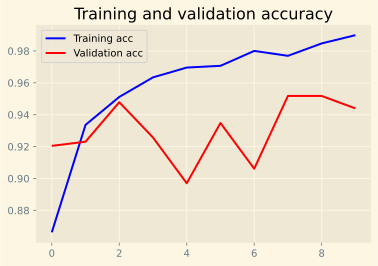

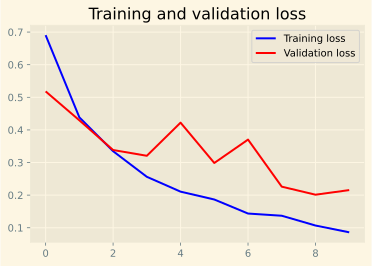

In [53]:
plot_history(history)

## Step 2

**На втором шаге разморозим половину слоев base_model и дообучим модель с уменьшенной Learning rate.**

In [89]:
LR = 0.0001


layers_unfreeze(base_model, 
                int(len(base_model.layers) // 2),  # размораживаем половину слоев
                model, 
                optimizers.Adam(learning_rate=LR, amsgrad=True))

In [ ]:
# Посмотрим количество слоев и их статус обучаемости
layers_info(model)

In [91]:
model.load_weights(f'{WORK_PATH}/best_model.hdf5')
model_evaluate(model, validation_generator)

24/24 [==============================] - 32s 1s/step - loss: 0.9105 - accuracy: 0.7823
Accuracy: 0.7823


In [92]:
%%time

# Обучаем
history = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    epochs=10, 
                    callbacks=recreate_callbacks())

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
459/459 [==============================] - 602s 1s/step - loss: 0.6308 - accuracy: 0.8800 - val_loss: 0.5037 - val_accuracy: 0.9074

Epoch 00001: val_accuracy improved from -inf to 0.90743, saving model to /content/drive/MyDrive/Colab Notebooks/deep learning/best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
459/459 [==============================] - 590s 1s/step - loss: 0.3722 - accuracy: 0.9449 - val_loss: 0.3334 - val_accuracy: 0.9439

Epoch 00002: val_accuracy improved from 0.90743 to 0.94394, saving model to /content/drive/MyDrive/Colab Notebooks/deep learning/best_model.hdf5
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
459/459 [==============================] - 589s 1s/step - loss: 0.2644 - accuracy: 0.9605 - val_loss: 0.2572 - val_accuracy: 0.9622

Epoch 00003: val_accuracy improved from 0.94394 to 0.96219, saving model to /content/drive/MyDrive/Colab Notebooks/deep learning/best_model.hdf5
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
459/459 [==============================] - 583s 1s/step - loss: 0.1898 - accuracy: 0.9707 - val_loss: 0.2400 - val_accuracy: 0.9478

Epoch 00004: val_accuracy 

In [93]:
# Сохраним модель и протестируем
model_save_step(model, step=2)
model_evaluate(model, validation_generator)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 26s 1s/step - loss: 0.1421 - accuracy: 0.9661
Accuracy: 0.9661


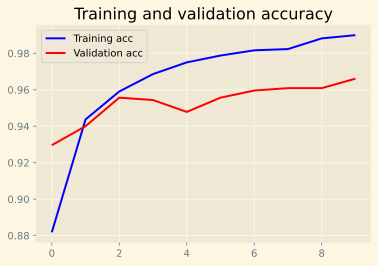

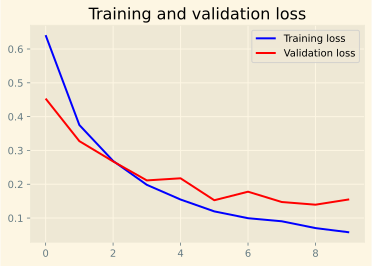

In [ ]:
plot_history(history)

In [66]:
# del model


## Step 3

**На третьем шаге разморозим все слои base_model и еще уменьшим Learning rate.**

In [94]:
LR = 0.00001


layers_unfreeze(base_model, 
                len(base_model.layers),  # размораживаем все слои
                model, 
                optimizers.Adam(learning_rate=LR, amsgrad=True))

In [95]:
# Посмотрим количество слоев и их статус обучаемости
layers_info(model)

Model <model_2> layers count: 390 (trainable vars: 187)

001 ✔️ input_3
002 ✔️ rescaling_2
003 ✔️ normalization_2
004 ✔️ stem_conv_pad
005 ✔️ stem_conv
006 ✖️ stem_bn
007 ✔️ stem_activation
008 ✔️ block1a_dwconv
009 ✖️ block1a_bn
010 ✔️ block1a_activation
011 ✔️ block1a_se_squeeze
012 ✔️ block1a_se_reshape
013 ✔️ block1a_se_reduce
014 ✔️ block1a_se_expand
015 ✔️ block1a_se_excite
016 ✔️ block1a_project_conv
017 ✖️ block1a_project_bn
018 ✔️ block1b_dwconv
019 ✖️ block1b_bn
020 ✔️ block1b_activation
021 ✔️ block1b_se_squeeze
022 ✔️ block1b_se_reshape
023 ✔️ block1b_se_reduce
024 ✔️ block1b_se_expand
025 ✔️ block1b_se_excite
026 ✔️ block1b_project_conv
027 ✖️ block1b_project_bn
028 ✔️ block1b_drop
029 ✔️ block1b_add
030 ✔️ block2a_expand_conv
031 ✖️ block2a_expand_bn
032 ✔️ block2a_expand_activation
033 ✔️ block2a_dwconv_pad
034 ✔️ block2a_dwconv
035 ✖️ block2a_bn
036 ✔️ block2a_activation
037 ✔️ block2a_se_squeeze
038 ✔️ block2a_se_reshape
039 ✔️ block2a_se_reduce
040 ✔️ block2a_se_expan

In [96]:
model.load_weights(f'{WORK_PATH}/best_model.hdf5')
model_evaluate(model, validation_generator)

24/24 [==============================] - 29s 1s/step - loss: 0.1461 - accuracy: 0.9700
Accuracy: 0.9700


In [78]:
LR = 0.00001

In [97]:
%%time

# Обучаем
history = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    epochs=10, 
                    callbacks=recreate_callbacks())

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
459/459 [==============================] - 1049s 2s/step - loss: 0.0419 - accuracy: 0.9950 - val_loss: 0.1478 - val_accuracy: 0.9674

Epoch 00001: val_accuracy improved from -inf to 0.96741, saving model to /content/drive/MyDrive/Colab Notebooks/deep learning/best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
459/459 [==============================] - 1033s 2s/step - loss: 0.0368 - accuracy: 0.9961 - val_loss: 0.1603 - val_accuracy: 0.9648

Epoch 00002: val_accuracy did not improve from 0.96741
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
459/459 [==============================] - 1032s 2s/step - loss: 0.0332 - accuracy: 0.9962 - val_loss: 0.1576 - val_accuracy: 0.9700

Epoch 00003: val_accuracy improved from 0.96741 to 0.97001, saving model to /content/drive/MyDrive/Colab Notebooks/deep learning/best_model.hdf5
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
459/459 [==============================] - 1031s 2s/step - loss: 0.0317 - accuracy: 0.9969 - val_loss: 0.1627 - val_accuracy: 0.9661

Epoch 00004: val_accuracy did not improve from 0.97001
Epoch 5/10

Epoch 00005: LearningRateScheduler setting lea

In [98]:
# Сохраним модель и протестируем
model_save_step(model, step=3)
model_evaluate(model, validation_generator)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 26s 1s/step - loss: 0.1752 - accuracy: 0.9687
Accuracy: 0.9687


In [ ]:
plot_history(history)

## Step 4

**На последнем шаге дообучаем сеть с увеличенным размером изображения.**

Также придется уменьшить batch, иначе сеть не влезет в память GPU.

In [99]:
IMG_SIZE             = 512
BATCH_SIZE           = 8
LR                   = 0.0001


# Пересоздаем генераторы данных с новыми гиперпараметрами
(train_generator, 
 validation_generator, 
 test_subgenerator) = rebuild_generators(target_size=(IMG_SIZE, IMG_SIZE), 
                                         batch_size=BATCH_SIZE, 
                                         val_split=VAL_SPLIT)

Found 14659 images belonging to 10 classes.
Found 767 images belonging to 10 classes.
Found 6675 validated image filenames.


In [100]:
# Загрузим предобученную сеть
base_model = EfficientNetB3(weights='imagenet', 
                            include_top=False, 
                            input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [101]:
# Задаем архитектуру "головы"
head = S([
    GlobalAveragePooling2D(), 
    Dense(128, use_bias=False, kernel_regularizer='l2'), 
    BatchNormalization(axis=1), 
    Activation('relu'), 
    Dropout(DROPOUT_RATE), 
    Dense(10, activation='softmax')
])

# Собираем модель
model = model_assemble(base_model, head)

# Компилируем
model.compile(optimizer=optimizers.Adam(learning_rate=LR, amsgrad=True), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Посмотрим количество слоев и их статус обучаемости
layers_info(model)

Model <model_3> layers count: 390 (trainable vars: 343)

001 ✔️ input_4
002 ✔️ rescaling_3
003 ✔️ normalization_3
004 ✔️ stem_conv_pad
005 ✔️ stem_conv
006 ✔️ stem_bn
007 ✔️ stem_activation
008 ✔️ block1a_dwconv
009 ✔️ block1a_bn
010 ✔️ block1a_activation
011 ✔️ block1a_se_squeeze
012 ✔️ block1a_se_reshape
013 ✔️ block1a_se_reduce
014 ✔️ block1a_se_expand
015 ✔️ block1a_se_excite
016 ✔️ block1a_project_conv
017 ✔️ block1a_project_bn
018 ✔️ block1b_dwconv
019 ✔️ block1b_bn
020 ✔️ block1b_activation
021 ✔️ block1b_se_squeeze
022 ✔️ block1b_se_reshape
023 ✔️ block1b_se_reduce
024 ✔️ block1b_se_expand
025 ✔️ block1b_se_excite
026 ✔️ block1b_project_conv
027 ✔️ block1b_project_bn
028 ✔️ block1b_drop
029 ✔️ block1b_add
030 ✔️ block2a_expand_conv
031 ✔️ block2a_expand_bn
032 ✔️ block2a_expand_activation
033 ✔️ block2a_dwconv_pad
034 ✔️ block2a_dwconv
035 ✔️ block2a_bn
036 ✔️ block2a_activation
037 ✔️ block2a_se_squeeze
038 ✔️ block2a_se_reshape
039 ✔️ block2a_se_reduce
040 ✔️ block2a_se_expan

In [102]:
model.load_weights(f'{WORK_PATH}/best_model.hdf5')
model_evaluate(model, validation_generator)

96/96 [==============================] - 70s 675ms/step - loss: 0.1349 - accuracy: 0.9609
Accuracy: 0.9609


In [103]:
%%time

# Обучаем
history = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    epochs=10, 
                    callbacks=recreate_callbacks())

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
1833/1833 [==============================] - 2777s 2s/step - loss: 0.2502 - accuracy: 0.9271 - val_loss: 0.1123 - val_accuracy: 0.9687

Epoch 00001: val_accuracy improved from -inf to 0.96871, saving model to /content/drive/MyDrive/Colab Notebooks/deep learning/best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
1833/1833 [==============================] - 2757s 2s/step - loss: 0.1448 - accuracy: 0.9616 - val_loss: 0.1127 - val_accuracy: 0.9739

Epoch 00002: val_accuracy improved from 0.96871 to 0.97392, saving model to /content/drive/MyDrive/Colab Notebooks/deep learning/best_model.hdf5
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
1833/1833 [==============================] - 2760s 2s/step - loss: 0.1166 - accuracy: 0.9719 - val_loss: 0.1514 - val_accuracy: 0.9726

Epoch 00003: val_accuracy did not improve from 0.97392
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
1833/1833 [==============================] - 2754s 2s/step - loss: 0.0937 - accuracy: 0.9798 - val_loss: 0.1073 - val_accuracy: 0.9791

Epoch 00004: val_accuracy improved from 0.97392 to 0.97914, saving model to /content/drive/MyDrive/Colab No

In [ ]:
show_stats(history, callbacks)

In [104]:
# Сохраним модель и протестируем
model_save_step(model, step=4)
model_evaluate(model, validation_generator)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


96/96 [==============================] - 64s 665ms/step - loss: 0.1078 - accuracy: 0.9817
Accuracy: 0.9817


In [ ]:
plot_history(history)

# Предсказание на тестовых данных

In [113]:
test_subgenerator.samples

6675

In [105]:
test_subgenerator.reset()

predictions = model.predict(test_subgenerator, verbose=1) 
predictions = np.argmax(predictions, axis=-1)

label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items()) # flip k, v
predictions = [label_map[k] for k in predictions]

835/835 [==============================] - 237s 282ms/step


In [106]:
submission = pd.DataFrame({'Id': test_subgenerator.filenames, 
                           'Category': predictions})

submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7


In [107]:
# Сохраним submission
from pathlib import Path

def save_submission(submission, suffix=None, dir_name='submissions'):
    Path(dir_name).mkdir(parents=True, exist_ok=True)
    now = dt.now().strftime('[%d.%m.%Y]-[%H-%M]')
    suffix = f'-{suffix}' if suffix else ''
    submission_name = f'{dir_name}/submission-{now}{suffix}.csv'
    submission.to_csv(submission_name, index=False)
    print(f'Submission saved as {submission_name}')
    
save_submission(submission)

Submission saved as submissions/submission-[15.09.2021]-[22-42].csv


# TTA (Test Time Augmentation)

https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

In [108]:
model.load_weights(WORK_PATH + 'best_model.hdf5')

In [109]:
test_datagen = ImageDataGenerator(rotation_range=10, 
                                  brightness_range=[0.5, 1.5], 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  horizontal_flip=True)

test_subgenerator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission, 
    directory=WORK_PATH + 'test_upload/', 
    x_col='Id', 
    y_col=None, 
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=BATCH_SIZE, 
    class_mode=None, 
    shuffle=False, 
    seed=RANDOM_SEED
)

Found 6675 validated image filenames.


In [110]:
tta_steps = 10   # берем среднее за 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict(test_subgenerator, verbose=1)
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

835/835 [==============================] - 464s 556ms/step


In [111]:
predictions = np.argmax(pred, axis=-1)

label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items()) # flip k, v

predictions = [label_map[k] for k in predictions]

submission = pd.DataFrame({'Id': test_subgenerator.filenames, 
                           'Category': predictions})

submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7


In [112]:
# Сохраним submission
save_submission(submission, suffix='TTA')

Submission saved as submissions/submission-[16.09.2021]-[00-00]-TTA.csv


# Заключение

- Основное тестирование для подбора гиперпараметров было решено проводить на сети EfficientNetB0

- Испытывались предобученные сети: EfficientNetE0, EfficientNetE3, EfficientNetE4, EfficientNetE6, EfficientNetE7;

Для финальной модели была выбрана EfficientNetE3 из-за оптимального рекомендованного размера входного изображения (300x300) и наилучшей эффективности.

- Заметный прирост точности показало добавление в архитектуру "головы" BatchNormalization


- Пробовались разные способы Augmentation, оптимальные параметры были выстравлены для финальной модели


- Тестировались следующие оптимизаторы:
    - Adam
    - Nadam
    - Adamax

Лучший результат показал `Adam` с параметром `amsgrad=True`

- Добавлена l2-регуляризация


- Применены различные Keras CallBacks:
  - ModelCheckpoint
  - EarlyStopping
  - ReduceLROnPlateau
  - LearningRateScheduler
  - TimingCallback
  
    
- Испробованы разные техники управления LR:
  - callback: LearningRateScheduler()
  [[>]](https://keras.io/api/callbacks/learning_rate_scheduler/)
  - callback: ReduceLROnPlateau()
  [[>]](https://keras.io/api/callbacks/reduce_lr_on_plateau/)
  - tf.keras.optimizers.schedules.ExponentialDecay()
  [[>]](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay)

Для финального решения была выбран LearningRateScheduler со scheduler `lr * tf.math.exp(decay_rate)`.


- Применена техника Test Time Augmentation, что дало небольшое улучшение точности.


Для настройки финальной модели было проведено большое количество экспериментов с разными значениями гиперпараметров (размер изображения, размер batch, Learning rate, количество эпох, оптимизаторы).

Fine-tuning показал себя хорошей работающей техникой, однако лучший результат в этом проекте был достигнут простым обучением в течение 20 эпох модели EfficientNetE3 с выставленными оптимальными для неё гиперпараметрами и с добавленной Test Time Augmentation.


---
Что не было сделано, но хотелось бы попробовать:

- Stratified-разбиение
- Динамическое увеличение размера картинки при Fine-tuning
- Другие стратегии разморозки слоев
- Cyclic Learning Rate
- Ансамблирование предобученных нейросетей
- Использование внешних датасетов для дообучения модели.